# Step 1 - Text Preprocessing

In [1]:
import pandas as pd
import langdetect
import string
import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to /home/stanislav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stanislav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Get the Data

In [2]:
# https://www.kaggle.com/adarshsng/predicting-job-type-category-by-job-description
df_train = pd.read_csv("raw_train.csv")
df_train.head()

,job_no,job_description,job_type,category
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
1,Id-22925,"En el mundo de los CRO's típicos, esta compañí...",Permanent,Clinical Research
2,Id-1321,Asha Mistry of Umbilical Life is recruiting an...,Contract/Interim,Pharmaceutical Marketing
3,Id-9473,Sales Representative - Laser in der Medizinte...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
4,Id-14952,Field Service Engineer - Life Science\r\r\r\nC...,Permanent,Manufacturing & Operations


In [3]:
df_train.isnull().sum()

job_no             0
job_description    0
job_type           0
category           0
dtype: int64

In [4]:
df_train['job_description'][0][:300]

" Zest Scientific is searching for an accomplished Scientific Sales professional in the Netherlands. This territory will play a pivotal role as the company increases their presence across Europe, presenting a wealth of untapped potential. Our client is internationally recognized for providing 'best i"

In [5]:
df_train.shape

(17657, 4)

In [6]:
df_train['job_type'].value_counts()

Permanent             15777
Contract/Interim       1414
Contract/Temp           305
Temporary/Seasonal      113
Any                      25
Part-Time                23
Name: job_type, dtype: int64

In [6]:
df_train['category'].value_counts()

Pharmaceutical, Healthcare and Medical Sales    4507
Clinical Research                               3172
Science                                         2932
Manufacturing & Operations                      2235
Regulatory Affairs                              1163
Pharmaceutical Marketing                        1071
Data Management and Statistics                   829
Quality-assurance                                703
Medical Information and Pharmacovigilance        561
Medical Affairs / Pharmaceutical Physician       458
Pharmacy                                          26
Name: category, dtype: int64

### Remove foreign texts 

In [7]:
df_train['lang'] = df_train['job_description'].apply(lambda x: langdetect.detect(x))
df_train.head()

,job_no,job_description,job_type,category,lang
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en
1,Id-22925,"En el mundo de los CRO's típicos, esta compañí...",Permanent,Clinical Research,es
2,Id-1321,Asha Mistry of Umbilical Life is recruiting an...,Contract/Interim,Pharmaceutical Marketing,en
3,Id-9473,Sales Representative - Laser in der Medizinte...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en
4,Id-14952,Field Service Engineer - Life Science\r\r\r\nC...,Permanent,Manufacturing & Operations,en


In [8]:
df_train['lang'].value_counts()

en    12356
es     1761
fr     1752
de     1744
it       38
sv        6
Name: lang, dtype: int64

In [9]:
df_train = df_train.drop(labels=[index for index, lang in enumerate(df_train['lang']) if lang != 'en'], axis=0)
df_train.head()

,job_no,job_description,job_type,category,lang
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en
2,Id-1321,Asha Mistry of Umbilical Life is recruiting an...,Contract/Interim,Pharmaceutical Marketing,en
3,Id-9473,Sales Representative - Laser in der Medizinte...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en
4,Id-14952,Field Service Engineer - Life Science\r\r\r\nC...,Permanent,Manufacturing & Operations,en
7,Id-16692,Due to increased business demand this award w...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en


In [10]:
df_train['lang'].value_counts()

en    12356
Name: lang, dtype: int64

In [11]:
df_train = df_train.drop(columns=['lang'], axis=1)

### Clean the Text

In [12]:
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree


df_train['job_description'] = df_train['job_description'].apply(lambda x: remove_punctuation(x))
# lowering the text
df_train['job_description'] = df_train['job_description'].apply(lambda x: x.lower())
df_train['job_description'][0][:300]

' zest scientific is searching for an accomplished scientific sales professional in the netherlands this territory will play a pivotal role as the company increases their presence across europe presenting a wealth of untapped potential our client is internationally recognized for providing best in cl'

### Tokenization

In [13]:
df_train['job_description'] = df_train['job_description'].apply(lambda x: word_tokenize(x))
print(df_train['job_description'][0][:20])

['zest', 'scientific', 'is', 'searching', 'for', 'an', 'accomplished', 'scientific', 'sales', 'professional', 'in', 'the', 'netherlands', 'this', 'territory', 'will', 'play', 'a', 'pivotal', 'role']


In [14]:
def clean(lst):
    new_lst = []
    for word in lst:
        if word.isalpha() and len(word) > 1:
            new_lst.append(word)
    return new_lst


df_train['job_description'] = df_train['job_description'].apply(lambda x: clean(x))
print(df_train['job_description'][0][:20])

['zest', 'scientific', 'is', 'searching', 'for', 'an', 'accomplished', 'scientific', 'sales', 'professional', 'in', 'the', 'netherlands', 'this', 'territory', 'will', 'play', 'pivotal', 'role', 'as']


### Remove stop words

In [15]:
stopwords_en = nltk.corpus.stopwords.words('english')

def remove_stopwords(lst):
    output = [i for i in lst if i not in stopwords_en]
    return output


df_train['job_description'] = df_train['job_description'].apply(lambda x: remove_stopwords(x))
print(df_train['job_description'][0][:20])

['zest', 'scientific', 'searching', 'accomplished', 'scientific', 'sales', 'professional', 'netherlands', 'territory', 'play', 'pivotal', 'role', 'company', 'increases', 'presence', 'across', 'europe', 'presenting', 'wealth', 'untapped']


### Stemming

In [16]:
porter_stemmer = PorterStemmer()

def stemming(lst):
    stem_text = [porter_stemmer.stem(word) for word in lst]
    return stem_text


df_train['job_description'] = df_train['job_description'].apply(lambda x: stemming(x))
print(df_train['job_description'][0][:20])

['zest', 'scientif', 'search', 'accomplish', 'scientif', 'sale', 'profession', 'netherland', 'territori', 'play', 'pivot', 'role', 'compani', 'increas', 'presenc', 'across', 'europ', 'present', 'wealth', 'untap']


## Visualization

In [17]:
def visualize(text):
    wordcloud = WordCloud(
        max_words=50,
        font_step=2,
        max_font_size=500,
        background_color='black'
    ).generate(text)
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(wordcloud);
    plt.show()

### Common words

Pharmaceutical, Healthcare and Medical Sales


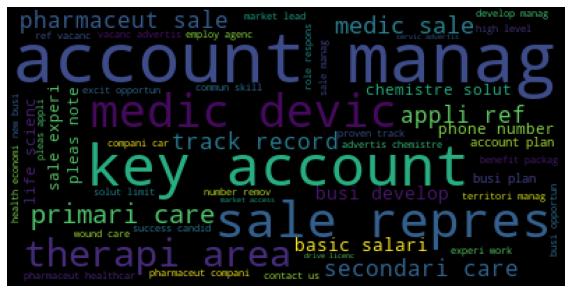

Pharmaceutical Marketing


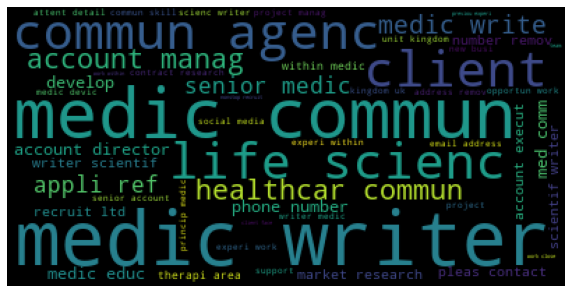

Manufacturing & Operations


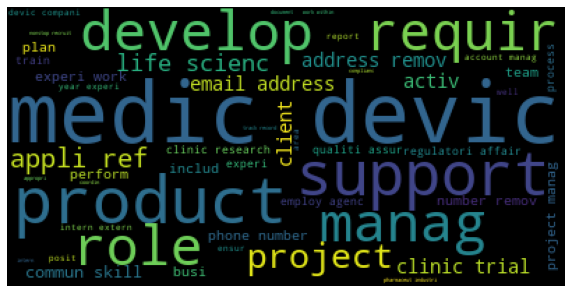

Science


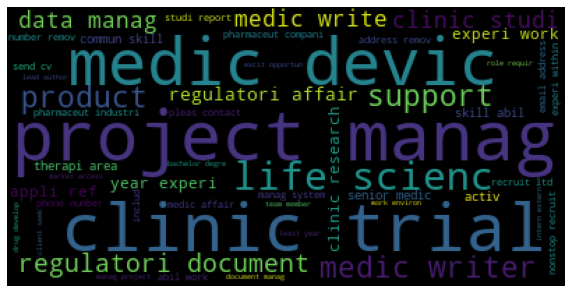

Clinical Research


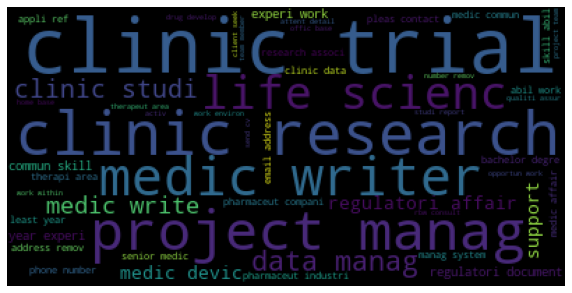

Regulatory Affairs


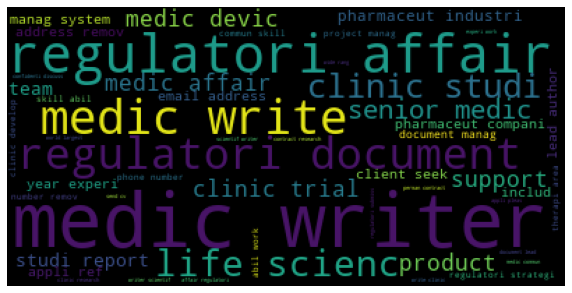

Data Management and Statistics


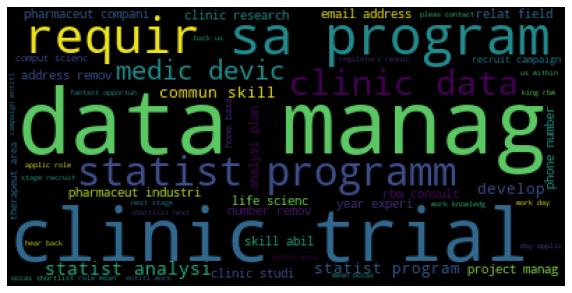

Medical Information and Pharmacovigilance


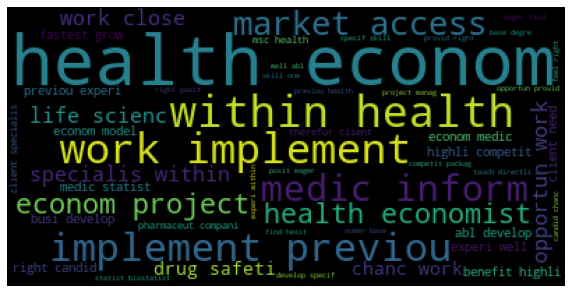

Medical Affairs / Pharmaceutical Physician


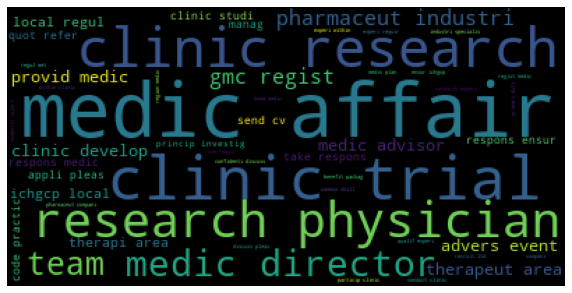

Quality-assurance


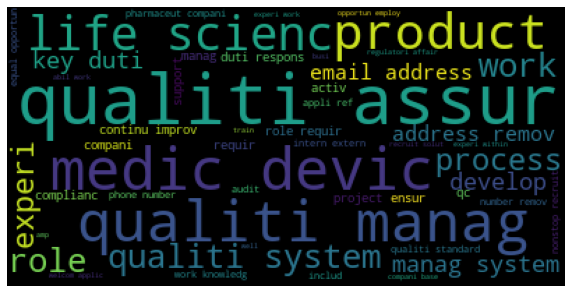

Pharmacy


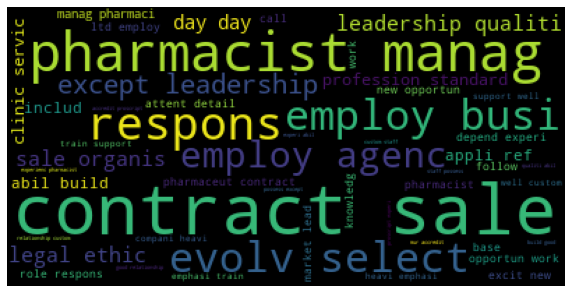

In [18]:
for label in df_train['category'].unique():
    print(label)
    text = ''
    for msg in df_train[df_train['category'] == label]['job_description']:
        text += " ".join(msg)
    visualize(text)

### Bi-grams

Pharmaceutical, Healthcare and Medical Sales


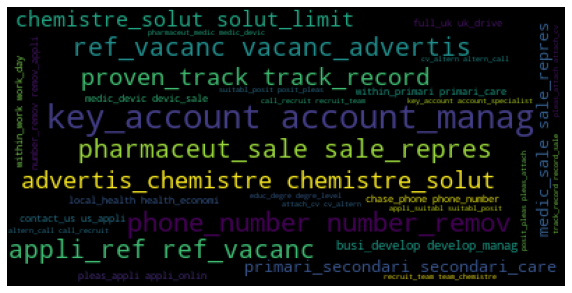

Pharmaceutical Marketing


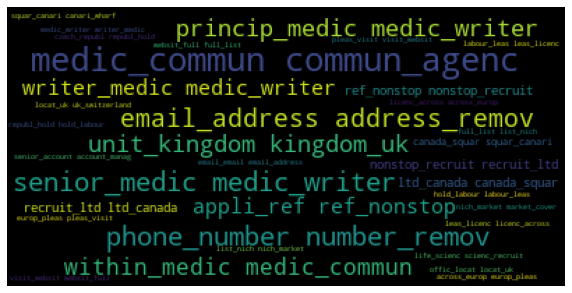

Manufacturing & Operations


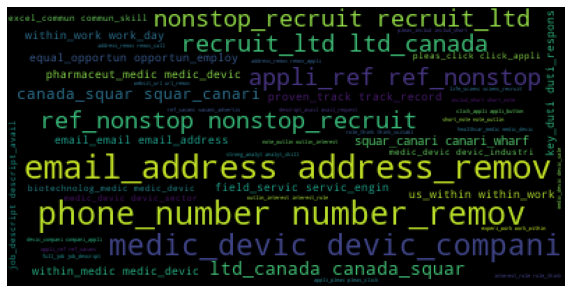

Science


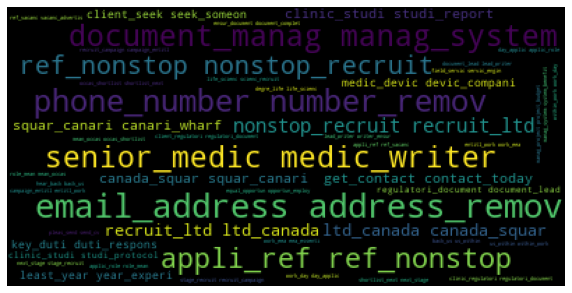

Clinical Research


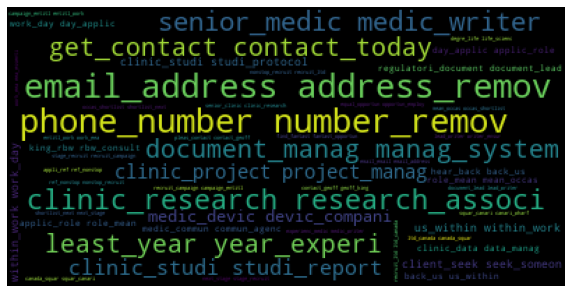

Regulatory Affairs


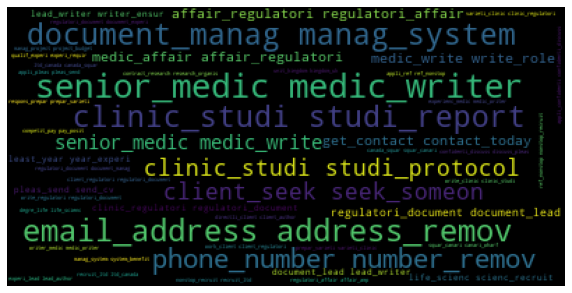

Data Management and Statistics


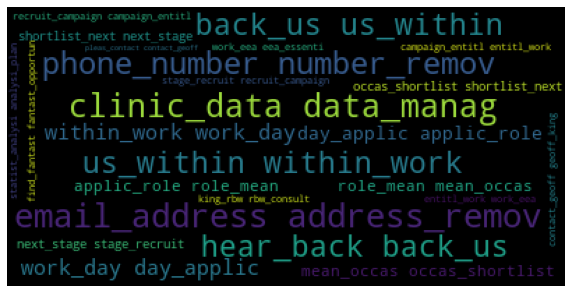

Medical Information and Pharmacovigilance


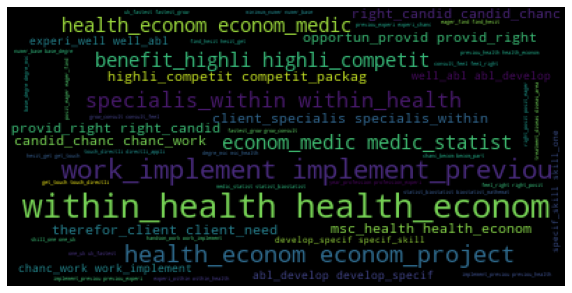

Medical Affairs / Pharmaceutical Physician


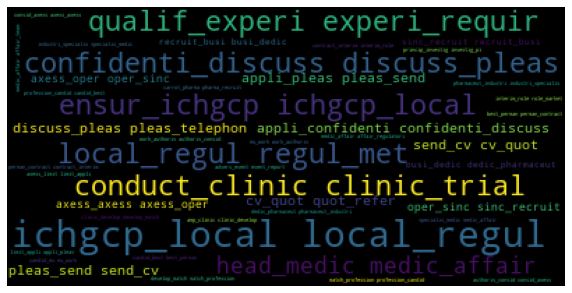

Quality-assurance


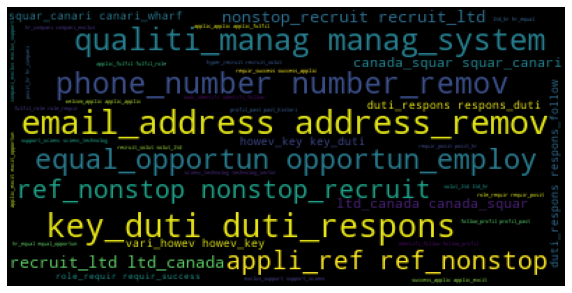

Pharmacy


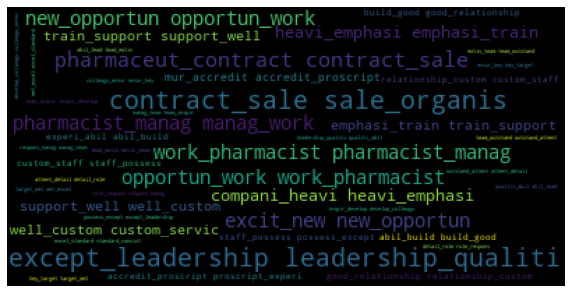

In [19]:
for label in df_train['category'].unique():
    print(label)
    text = ''
    for msg in df_train[df_train['category'] == label]['job_description']:
        text += " ".join([w1 + '_' + w2 for w1, w2 in nltk.bigrams(msg)])
    visualize(text)

In [20]:
# save preprocessed data
df_train.to_csv("preprocessed_train.csv", index=False)

### Preprocess test dataset

In [21]:
df_test = pd.read_csv("raw_test.csv")
df_test.head()

,job_no,job_description
0,Id-1,SAS Statistical Programmer II. UK. SDTM. ADaM....
1,Id-2,Therapy Area: Respiratory\r\r\r\nPackage: Nego...
2,Id-4,RBW consulting are working in partnership with...
3,Id-6,One of my long term clients is currently look...
4,Id-7,Unique package - Statistical Programmer - CRO\...


In [22]:
df_test.shape

(11771, 2)

In [23]:
df_test.isnull().sum()

job_no             0
job_description    0
dtype: int64

In [24]:
def preprocess_the_data(df):
    # find and remove foreign texts
    df['lang'] = df['job_description'].apply(lambda x: langdetect.detect(x))
    df = df.drop(labels=[index for index, lang in enumerate(df['lang']) if lang != 'en'], axis=0)
    df = df.drop(columns=['lang'], axis=1)
    # remove punktuation
    df['job_description'] = df['job_description'].apply(lambda x: remove_punctuation(x))
    # lowering the text
    df['job_description'] = df['job_description'].apply(lambda x: x.lower())
    # tokenization
    df['job_description'] = df['job_description'].apply(lambda x: word_tokenize(x))
    df['job_description'] = df['job_description'].apply(lambda x: clean(x))
    # remove stop-words
    df['job_description'] = df['job_description'].apply(lambda x: remove_stopwords(x))
    # stemming
    df['job_description'] = df['job_description'].apply(lambda x: stemming(x))
    return df

In [25]:
preprocessed_test = preprocess_the_data(df_test)
preprocessed_test.head()

,job_no,job_description
0,Id-1,"[sa, statist, programm, ii, uk, sdtm, adam, tf..."
1,Id-2,"[therapi, area, respiratori, packag, negoti, b..."
2,Id-4,"[rbw, consult, work, partnership, specialist, ..."
3,Id-6,"[one, long, term, client, current, look, exper..."
4,Id-7,"[uniqu, packag, statist, programm, cro, approa..."


In [26]:
# save preprocessed data
preprocessed_test.to_csv("preprocessed_test.csv", index=False)